In [1]:
cd ../..

/home/asingal/home/quisp/SeQUeNCe_quisp


/home/asingal/home/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt

from src.topology.router_net_topo import RouterNetTopo
from src.app.request_app import RequestApp
import src.utils.log as log

from datetime import date, datetime
today = date.today()

In [3]:
CONFIG_FILE = "example/SC24/config_files/simple_link.json"

# meta params
NO_TRIALS = 15
OUTPUT_FILE = f"results/variable_distance{str(today)}.csv"
LOGGING = False
LOG_OUTPUT = "results/var_mem_log.csv"
MODULE_TO_LOG = ["timeline", "memory", "bsm", "generation", "request_app", "optical_channel", "resource_manager"]


In [4]:
# simulation params
PREP_TIME = int(1e12)  # 1 second
COLLECT_TIME = int(2.5e12)  # 3.1, 10 seconds

# qc params
QC_FREQ = 1e11
total_distance = 20  # (unit: km)
distances = list(range(0,11))  # iterate through these (unit: km). distance of bsm from left. 

# application params
APP_NODE_NAME = "left"
OTHER_NODE_NAME = "right"
num_memo = 1

# storing data
data_dict = {"Distance": [],
             "Average Throughput": [],
             "Std. Throughput": [],
             "Average TTT": [],
             "Std. TTT":[],
             "probs":[]}

In [5]:
for i, distance in enumerate(distances):
    print(f"Running {NO_TRIALS} trials for distance {distance}km ({i + 1}/{len(distances)})")
    data_dict["Distance"].append(distance)
    throughputs = np.zeros(NO_TRIALS)
    time_to_thousand = np.zeros(NO_TRIALS)
    probs = np.zeros(NO_TRIALS)

    for trial_no in range(NO_TRIALS):
        # establish network
        net_topo = RouterNetTopo(CONFIG_FILE)

        # timeline setup
        tl = net_topo.get_timeline()
        tl.stop_time = PREP_TIME + COLLECT_TIME

        # Logging stuff
        if LOGGING:
            # set log
            if i == 3:
                log.set_logger(__name__, tl, LOG_OUTPUT)
                log.set_logger_level('WARN')
                for module in MODULE_TO_LOG:
                    log.track_module(module)
            elif i == 4:
                for module in MODULE_TO_LOG:
                    log.remove_module(module)

        # network configuration
        routers = net_topo.get_nodes_by_type(RouterNetTopo.QUANTUM_ROUTER)
        bsm_nodes = net_topo.get_nodes_by_type(RouterNetTopo.BSM_NODE)

        for j, node in enumerate(routers + bsm_nodes):
            node.set_seed(j + (trial_no * 3))

        # set quantum channel parameters
        left_distance = distance
        right_distance = total_distance - distance
        for qc in net_topo.get_qchannels():
            qc.frequency = QC_FREQ
            if qc.sender.name == APP_NODE_NAME:
                qc.distance = left_distance * 1e3
            elif qc.sender.name == OTHER_NODE_NAME:
                qc.distance = right_distance * 1e3
            else:
                raise Exception(f"Invalid sender node name '{qc.sender.name}'")
            
        for cc in net_topo.get_cchannels():
            # print(cc.sender.name, ",", cc.receiver, ",", APP_NODE_NAME, ",", OTHER_NODE_NAME, bsm_nodes[0].name)
            if cc.sender.name == bsm_nodes[0].name:
                if cc.receiver == APP_NODE_NAME:
                    cc.delay = left_distance * 1e3/cc.light_speed
                elif cc.receiver == OTHER_NODE_NAME:
                    cc.delay = right_distance * 1e3/cc.light_speed

            elif cc.receiver == bsm_nodes[0].name:
                if cc.sender.name == APP_NODE_NAME:
                    cc.delay = left_distance * 1e3/cc.light_speed
                elif cc.sender.name == OTHER_NODE_NAME:
                    cc.delay = right_distance * 1e3/cc.light_speed
                
        # establish app on left node
        start_node = None
        for node in routers:
            if node.name == APP_NODE_NAME:
                start_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid app node name {APP_NODE_NAME}")
        end_node = None
        for node in routers:
            if node.name == OTHER_NODE_NAME:
                end_node = node
                break
        if not start_node:
            raise ValueError(f"Invalid other node name {OTHER_NODE_NAME}")

        app_start = RequestApp(start_node)
        app_end = RequestApp(end_node)

        # initialize and start app
        tl.init()
        app_start.start(OTHER_NODE_NAME, PREP_TIME, PREP_TIME + COLLECT_TIME, num_memo, 1.0)
        tl.run()

        # Used for debugging
        attempt = app_start.node.total_attempts
        success = app_start.node.succesful_attempts
        prob = success/attempt

        throughputs[trial_no] = app_start.get_throughput()
        time_to_thousand[trial_no] = app_start.node.time_to_thousand
        probs[trial_no] = prob
        print(f"\tCompleted trial {trial_no + 1}/{NO_TRIALS}")

    print("Finished trials.")

    avg_throughput = np.mean(throughputs)
    std_throughput = np.std(throughputs)
    avg_TTT = np.mean(time_to_thousand)
    std_TTT = np.std(time_to_thousand)

    avg_prob = np.mean(probs)
    print(f"Average throughput: {avg_throughput} +/- {std_throughput}")
    print(f"time to thousand entanglements:", time_to_thousand)

    data_dict["Average Throughput"].append(avg_throughput)
    data_dict["Std. Throughput"].append(std_throughput)
    data_dict["Average TTT"].append(avg_TTT/1e12)
    data_dict["Std. TTT"].append(std_TTT/1e12)
    data_dict["probs"].append(avg_prob)

df = pd.DataFrame(data_dict)
df

Running 15 trials for distance 0km (1/11)
	Completed trial 1/15
	Completed trial 2/15
	Completed trial 3/15
	Completed trial 4/15
	Completed trial 5/15
	Completed trial 6/15
	Completed trial 7/15
	Completed trial 8/15
	Completed trial 9/15
	Completed trial 10/15
	Completed trial 11/15
	Completed trial 12/15
	Completed trial 13/15
	Completed trial 14/15
	Completed trial 15/15
Finished trials.
Average throughput: 495.68000000000006 +/- 12.228229634742723
time to thousand entanglements: [2.05880010e+12 1.93360010e+12 1.96560010e+12 1.94560010e+12
 2.02680010e+12 1.97720010e+12 2.03560010e+12 1.97760010e+12
 1.99600010e+12 2.11480011e+12 1.97920010e+12 2.05440010e+12
 2.07680010e+12 2.07600010e+12 1.94800010e+12]
Running 15 trials for distance 1km (2/11)
	Completed trial 1/15
	Completed trial 2/15
	Completed trial 3/15
	Completed trial 4/15
	Completed trial 5/15
	Completed trial 6/15
	Completed trial 7/15
	Completed trial 8/15
	Completed trial 9/15
	Completed trial 10/15
	Completed trial 1

,Distance,Average Throughput,Std. Throughput,Average TTT,Std. TTT,probs
0,0,495.680000,12.228230,2.011067,0.054249,0.198304
1,1,496.853333,11.324891,1.999360,0.048347,0.198773
2,2,500.800000,15.354999,1.982987,0.065107,0.200352
3,3,500.026667,12.253732,2.004587,0.041062,0.200043
4,4,495.573333,12.348250,2.015840,0.045214,0.198261
5,5,499.946667,15.969883,2.008987,0.075674,0.200011
6,6,492.373333,9.414278,2.034587,0.047536,0.196981
7,7,499.440000,13.880096,1.999147,0.061456,0.199808
8,8,497.360000,11.752832,1.995040,0.040061,0.198976
9,9,499.866667,10.951205,1.998533,0.047134,0.199979


,Distance,Average Throughput,Std. Throughput,Average TTT,Std. TTT,probs
0,0,495.680000,12.228230,2.011067,0.054249,0.198304
1,1,496.853333,11.324891,1.999360,0.048347,0.198773
2,2,500.800000,15.354999,1.982987,0.065107,0.200352
3,3,500.026667,12.253732,2.004587,0.041062,0.200043
4,4,495.573333,12.348250,2.015840,0.045214,0.198261
5,5,499.946667,15.969883,2.008987,0.075674,0.200011
6,6,492.373333,9.414278,2.034587,0.047536,0.196981
7,7,499.440000,13.880096,1.999147,0.061456,0.199808
8,8,497.360000,11.752832,1.995040,0.040061,0.198976
9,9,499.866667,10.951205,1.998533,0.047134,0.199979


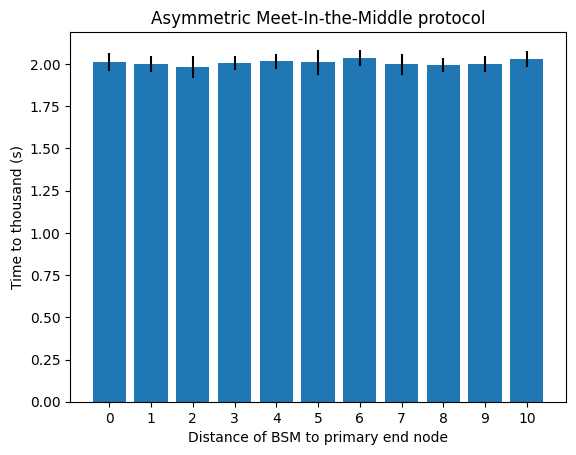

In [6]:
plt.bar(range(len(df["Average TTT"])), df["Average TTT"], yerr = df["Std. TTT"], tick_label = df["Distance"])
plt.ylabel("Time to thousand (s)")
plt.xlabel("Distance of BSM to primary end node")
plt.title("Asymmetric Meet-In-the-Middle protocol")
df